# DL1b to DL2

#### Purpose of this notebook
#### 1. Check DL1b data processed by OSA
#### 2. Check Random forest models produced by lstmcpipe
#### 3. DL1b to DL2 step (observation data)
#### 4. Explore DL2 data
#### 5. Source-dependent analysis

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.stats import WStatCountsStatistic

In [2]:
import lstchain
from lstchain.reco.utils import get_effective_time #, radec_to_camera\
from ctapipe.containers import EventType
from lstchain.io.io import (
    dl1_params_lstcam_key,
    dl2_params_lstcam_key,
    dl2_params_src_dep_lstcam_key,
    get_dataset_keys
)
from lstchain.io import (
    standard_config,
    srcdep_config,
    get_srcdep_params, 
    get_srcdep_assumed_positions
)
from lstchain.reco.utils import (
    compute_theta2,
    extract_source_position,
    get_effective_time
)

In [3]:
# Test data are stored under the following directory on La Palma IT cluster
# If you are locally running this notebook, please change the data directory path|
data_dir = '/fefs/aswg/workspace/analysis-school-2024/DL1b_to_DL2/'

In [4]:
lstchain_dir = os.path.dirname(lstchain.__file__)

# 1. Check DL1b data processed by OSA

#### Before checking the observation data

Please check the run list and observation conditions:
- LST observation schedule: https://www.lst1.iac.es/schedule/
- ELOG: https://www.lst1.iac.es/elog/LST+commissioning/
- OSA source catalog: https://www.lst1.iac.es/datacheck/lstosa/LST_source_catalog.html
- DL1 data check: https://www.lst1.iac.es/datacheck/dl1/
- Observation overview: https://www.lst1.iac.es/datacheck/observation_overview/


#### Check OSA directory structure

OSA (Onsite analysis, https://github.com/cta-observatory/lstosa) process starts at 8UTC to create DL1 data. The OSA process is running under `/fefs/aswg/data/real/running_analysis`, then the OSA products are moved to `/fefs/aswg/data/real/DL1` once all the processes are finished. The status of the processing can be seen here (https://www.lst1.iac.es/datacheck/lstosa/sequencer.xhtml). After that, you can see the processed observation runs in the source catalog page (https://www.lst1.iac.es/datacheck/lstosa/LST_source_catalog.html).

OSA DL1 directory is `/fefs/aswg/data/real/DL1/`. There are three directories under the corresponding DATE and LSTCHAIN_VERSION directory: 
- `interleaved`: interleaved calibration file for Cat-B calibration
- `muons`: muon analysis products
- `tailcut84`: DL1b data (still containing DL1a image data) after the standard tailcuts cleaning of picture threshold 8 p.e. and boundary threshold 4 p.e + pedestal-noise-based threshold.

In [5]:
date='20231216'
lstchain_version='v0.10'

#date="20221031"
#lstchain_version='v0.9'

!ls /fefs/aswg/data/real/DL1/{date}/{lstchain_version}/ 

interleaved  muons  tailcut84


There are two steps before the DL1b data are created:
1. Apply calibration and create DL1a data (pixel-wise image data) (`lstchain_data_r0_to_dl1`) 
2. Create DL1b data by applying the image clearning with the pedestal noise information derived from the interleaved pedestal events (`lstchain_dl1ab`)

First, DL1a data (pixel-wise image data) are created for each subrun. During this step, pixel-wise pedestal noise values are computed using the interleaved pedestal events and stored in the DL1a data. The pixel-wise pedestal noise values correspond to the night sky background levels on each pixel. If there is a bright star inside the camera field of view, this value on that pixel can be higher than other pixels. In this case, we need to apply higher image clearning level (2.5 x pedestal noise in the standard config) to this pixel to avoid noise events. So, we can apply the image clearning with pedestal threshold. 

In [6]:
print("The standard image cleaning configurations:")
print(standard_config['tailcuts_clean_with_pedestal_threshold'])
print(standard_config['dynamic_cleaning'])

The standard image cleaning configurations:
{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
{'apply': True, 'threshold': 267, 'fraction_cleaning_intensity': 0.03}


#### Check DL1b file

DL1b data are stored under `tailcut84` directory. This process (DL1a to DL1b) is performed for each subrun file. Each subrun file contains 5-6k events (depending on EVB version) corresponding to ~10 seconds observation and 20-min obserbations have ~100-200 subrun files. The file name of DL1 data is `dl1-1.Run{run_id}.{subrun_id}.h5`.

In [7]:
run_id = '16179'
subrun_id = '0000'

!ls /fefs/aswg/data/real/DL1/{date}/{lstchain_version}/tailcut84/dl1_LST-1.Run{run_id}.{subrun_id}.h5 

/fefs/aswg/data/real/DL1/20231216/v0.10/tailcut84/dl1_LST-1.Run16179.0000.h5


In this directory, the merged DL1b data (DL1a image data are removed) are also stored for each observation run.

In [8]:
!ls /fefs/aswg/data/real/DL1/{date}/{lstchain_version}/tailcut84/dl1_LST-1.Run{run_id}.h5 

/fefs/aswg/data/real/DL1/20231216/v0.10/tailcut84/dl1_LST-1.Run16179.h5


The dataset key of DL1b level is `/dl1/event/telescope/parameters/LST_LSTCam` (=`dl1_params_lstcam_key`). 

In [9]:
input_dl1_file = '/fefs/aswg/data/real/DL1/20231216/v0.10/tailcut84/dl1_LST-1.Run16179.0000.h5'
#input_dl1_file = f'{data_dir}/DL1b/dl1_LST-1.Run02008.0000.h5'
get_dataset_keys(input_dl1_file)

['/source_filenames/filenames',
 '/dl1/event/telescope/image/LST_LSTCam',
 '/dl1/event/telescope/monitoring/calibration',
 '/dl1/event/telescope/monitoring/flatfield',
 '/dl1/event/telescope/monitoring/pedestal',
 '/dl1/event/telescope/parameters/LST_LSTCam',
 '/configuration/instrument/subarray/layout',
 '/configuration/instrument/telescope/optics',
 '/configuration/instrument/telescope/camera/geometry_0',
 '/configuration/instrument/telescope/camera/readout_0']

#### Check DL1b parameters

DL1b data contains shower image parameters after the image cleaning. Even if a given event doesn't survive after the image cleaning, each event is stored in DL1b data to save `delta_t` (delta time between events) for the effective time calculation later. Those un-survived events after the clearning have `NaN` value in each shower parameter.

In [10]:
# Read DL1b data frame
dl1b_data = pd.read_hdf(input_dl1_file, key=dl1_params_lstcam_key)
dl1b_data

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
0,16179,1,5656.835428,3.752574,0.008245,-0.022202,0.023683,-1.215231,1.137678,0.007587,...,-9999,0.969063,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
1,16179,2,62.134762,1.793335,-0.565006,0.595677,0.821013,2.329776,0.061903,0.004842,...,-9999,0.977951,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
2,16179,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
3,16179,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
4,16179,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59803,16179,59804,103.183806,2.013612,0.888019,-0.288080,0.933578,-0.313696,0.138815,0.006223,...,-9999,0.493451,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
59804,16179,59805,193.756116,2.287255,-0.027583,-0.746893,0.747402,-1.607710,0.102977,0.004522,...,-9999,0.587665,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
59805,16179,59806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32
59806,16179,59807,360.338927,2.556711,0.528392,-0.790107,0.950509,-0.981345,0.202524,0.004601,...,-9999,0.428583,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32


You can also check how much fraction of the interleaved pedestal events survives after the image cleaning. If the fraction is too high (like >10%), the NSB level is too high and you need to apply the higher image cleaning threshold.

In [11]:
# Survived pedestal event ratio
pedestal_data = dl1b_data[dl1b_data.event_type == EventType.SKY_PEDESTAL.value]
n_all_ped_events = len(pedestal_data)
n_survived_ped_events = np.sum(~np.isnan(pedestal_data.intensity))
survived_ped_events_ratio = n_survived_ped_events/n_all_ped_events 

print(f"Survived pedestal events: {survived_ped_events_ratio*100:.1f}% ({n_survived_ped_events}/{n_all_ped_events} events)")

Survived pedestal events: 0.7% (5/671 events)


DL1b parameters contain the shower image, time information, trigger information, pointing information etc. You can check the definition of each parameter in `DL1ParametersContainer`
https://cta-observatory.github.io/cta-lstchain/api/lstchain.io.lstcontainers.DL1ParametersContainer.html

In [12]:
# DL1 parameters keys
dl1_keys = dl1b_data.keys()
dl1_keys

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'length_uncertainty', 'width', 'width_uncertainty',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'sin_az_tel', 'calibration_id',
       'dragon_time', 'ucts_time', 'tib_time', 'ucts_jump', 'mc_type', 'wl',
       'tel_id', 'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type',
       'ucts_trigger_type', 'trigger_time', 'event_type'],
      dtype='object')

In [13]:
# release the memory
del dl1b_data

# 2. Check random forest models produced by lstmcpipe

Random forest (RF) models are created by `lstmcpipe` (https://github.com/cta-observatory/lstmcpipe). The `lstmcpipe` products are stored under the following directory. `PROD_ID` is MC production-based directory (e.g. `20240131_allsky_v0.10.5_all_dec_base`), `DEC` is for the corresponding declination line (e.g. `dec_2276`).
- `/fefs/aswg/data/mc/DL1/AllSky/PROD_ID/TrainingDataset/DEC/{GammaDiffuse, Protons}`: Training DL1 MC
- `/fefs/aswg/data/mc/DL1/AllSky/PROD_ID/TestingDataset/DEC/`: Test DL1 MC
- `/fefs/aswg/data/models/AllSky/PROD_ID/DEC`: RF models
- `/fefs/aswg/data/mc/DL2/AllSky/PROD_ID/TestingDataset/DEC`: Test DL2 MC

#### Check declination-based random forest models

There are several RF models for the corresponding declination line. You need to choose the best RF models of which declination is close to the target source declination.

In [14]:
production_id = "20240131_allsky_v0.10.5_all_dec_base"
declination_dir = "dec_2276" # DEC=22.76 deg

!ls /fefs/aswg/data/models/AllSky/{production_id}

dec_2276  dec_4822  dec_6676  dec_min_1802  dec_min_413
dec_3476  dec_6166  dec_931   dec_min_2924


In [15]:
def get_alt_az_for_target_dec(dec_target):
    
    latitude  = 28.76139 * u.deg # LST-1
    local_hour_angle = np.linspace(-180, 180, 200) * u.deg
    alt = np.arcsin(np.sin(dec_target) * np.sin(latitude) + np.cos(dec_target) * np.cos(latitude) * np.cos(local_hour_angle))
    az = np.arcsin(- np.sin(local_hour_angle) * np.cos(dec_target)/np.cos(alt))
    zd = 90 * u.deg - alt
    
    culmination_zd = latitude - dec_target
    print(f"Target declination: {dec_target.degree} deg, Culmination is Zd = {np.abs(culmination_zd):.2f}")

    select_zd90 = zd < 90 * u.deg
    zd_cut = zd[select_zd90]
    az_cut = az[select_zd90]
    
    zd_az90 = zd_cut[np.argmin(np.abs(az_cut - 90 * u.deg))]
    
    # azimuth is coputed within [-pi, pi], so it is needed to convert to the range within [pi, 1.5*pi] for south pointing points
    if culmination_zd > 0 * u.deg:
        select_south = zd_cut < zd_az90
        az_cut[select_south] = (az_cut[select_south] + 180 * u.deg)
        az_cut[select_south] = az_cut[select_south][::-1]
        
    return az_cut, zd_cut

In [16]:
coord_target = SkyCoord.from_name("Crab")
dec_target = coord_target.dec

Target declination: 22.0147 deg, Culmination is Zd = 6.75 deg


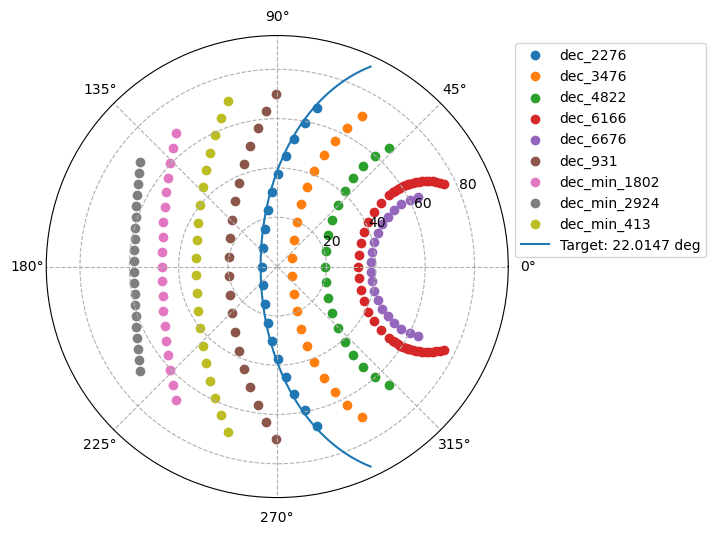

In [17]:
dec_dir_list = sorted(glob.glob(f"/fefs/aswg/data/mc/DL1/AllSky/{production_id}/TrainingDataset/dec_*"))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='polar')

for dec_dir in dec_dir_list:
    dec_dir_basename = os.path.basename(dec_dir)

    if 'dec_min' in dec_dir_basename:
        dec_mc = float(dec_dir_basename.replace("dec_min_", "")) * 1e-2 * -1
    else:
        dec_mc = float(dec_dir_basename.replace("dec_", "")) * 1e-2

    node_dir_list = sorted(glob.glob(f"{dec_dir}/GammaDiffuse/node*"))

    mc_zenith_list = []
    mc_azimuth_list = []

    for node_dir in node_dir_list:
        node_dir_basename_split = os.path.basename(node_dir).split('_')
        zd_tel = np.deg2rad(float(node_dir_basename_split[3]))
        az_tel = np.deg2rad(float(node_dir_basename_split[5]))
    
        mc_zenith_list.append(zd_tel)
        mc_azimuth_list.append(az_tel)
   
    plt.scatter(mc_azimuth_list, np.rad2deg(mc_zenith_list), label=dec_dir_basename)

az, zd = get_alt_az_for_target_dec(dec_target)
#plt.plot(az, zd, label=f"Target: {dec_target.to_value(u.degree)} deg")
plt.plot(az, zd, label=f"Target: {dec_target.degree} deg")

plt.grid(ls='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Check RF models 

Trained model files (scikit-learn) are stored in this directory. There is also a configuration json file for the RF training. You need to use the same configurations (input parameters etc) for DL2 data production.
- `reg_energy.sav`: energy regression (`reco_energy`)
- `cls_disp_sign.sav`: arrival direction reconstruction (`disp_sign`)
- `reg_disp_norm.sav`: arrival direction reconstruction (`disp_norm`)
- `cls_gh.sav`: particle type classification (`gammaness`)

In [18]:
!ls /fefs/aswg/data/models/AllSky/{production_id}/{declination_dir}

cls_disp_sign.sav	       job_plot_rf_feat_importance.o	reg_energy.sav
cls_gh.sav		       lstchain_config_2024-01-31.json	train_job.e
job_plot_rf_feat_importance.e  reg_disp_norm.sav		train_job.o


# 3. DL1b to DL2 step (observation data)

#### Script usage

You can check the usage of the script: `lstchain_dl1_to_dl2 -h`

```
usage: lstchain_dl1_to_dl2 [-h] --input-files INPUT_FILES [INPUT_FILES ...] [--path-models PATH_MODELS] [--output-dir OUTPUT_DIR]
                           [--config CONFIG_FILE]

Run the DL1 to DL2 step: Pipeline for the reconstruction of Energy, disp and gamma/hadron separation of events stored in a DL1 file. It
takes DL1 file(s) and trained Random Forests as input and outputs DL2 data file(s). Run lstchain_dl1_to_dl2 --help to see the options.

options:
  -h, --help            show this help message and exit
  --input-files INPUT_FILES [INPUT_FILES ...], -f INPUT_FILES [INPUT_FILES ...]
                        Path (or list of paths) to a DL1 HDF5 file
  --path-models PATH_MODELS, -p PATH_MODELS
                        Path where to find the trained RF
  --output-dir OUTPUT_DIR, -o OUTPUT_DIR
                        Path where to store the reco dl2 events
  --config CONFIG_FILE, -c CONFIG_FILE
                        Path to a configuration file. If none is given, a standard configuration is applied

```

#### Launch the script with small test data

In [19]:
input_dl1_file = f'{data_dir}/DL1b/dl1_LST-1.Run02008.0000.h5'
model_path = f'{data_dir}/models/srcindep/'
output_dir = './DL2_ouput_srcindep'
os.makedirs(output_dir, exist_ok=True)
config_file = f'{lstchain_dir}/data/lstchain_standard_config.json'

In [20]:
!lstchain_dl1_to_dl2 -f {input_dl1_file} -p {model_path} -o {output_dir} -c {config_file}

/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/site-packages/lstchain/reco/utils.py:535: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
Data contains not-predictable events.
Column | Number of non finite values
leakage_intensity_width_2 : 87
time_gradient : 92
skewness : 87
wl : 87
log_intensity : 87
y : 87
width : 87
kurtosis : 87
length : 87
x : 87
/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/site-packages/lstchain/reco/utils.py:535: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/site-packages/sklearn/utils/validation.py:767: Future

# 4. Explore DL2 data

#### Check DL2 parameters

Here let's use the already-processed DL2 data (run 16179, merge of 50 subruns).

In [21]:
dl2_file_path = f'{data_dir}/DL2/srcindep/dl2_LST-1.Run16179_small.h5'

You can see `/dl2/event/telescope/parameters/LST_LSTCam` (=`dl2_params_lstcam_key`) are added in dataset keys.

In [22]:
get_dataset_keys(dl2_file_path)

['/source_filenames/filenames',
 '/dl2/event/telescope/parameters/LST_LSTCam',
 '/dl1/event/telescope/monitoring/calibration',
 '/dl1/event/telescope/monitoring/flatfield',
 '/dl1/event/telescope/monitoring/pedestal',
 '/configuration/instrument/subarray/layout',
 '/configuration/instrument/telescope/optics',
 '/configuration/instrument/telescope/camera/geometry_0',
 '/configuration/instrument/telescope/camera/readout_0']

In [23]:
data = pd.read_hdf(dl2_file_path, key=dl2_params_lstcam_key)
data

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,signed_time_gradient,signed_skewness,reco_alt,reco_az,reco_type,gammaness
0,16179,1,5656.835428,3.752574,0.008245,-0.022202,0.023683,-1.215231,1.137678,0.007587,...,-0.046210,0.261865,-0.037965,0.239664,-1.007624,-0.144647,1.325868,4.315609,101,0.017572
1,16179,2,62.134762,1.793335,-0.565006,0.595677,0.821013,2.329776,0.061903,0.004842,...,0.069146,-0.283713,-0.495860,0.311964,11.404015,0.694361,1.310164,4.323192,101,0.488485
2,16179,6,118.360357,2.073206,-0.107376,-0.948771,0.954828,-1.683491,0.076276,0.005181,...,-0.040140,0.177087,-0.147516,-0.771684,8.432012,0.522818,1.320900,4.175212,101,0.241387
3,16179,13,60.150925,1.779242,0.073985,0.720996,0.724782,1.468539,0.065001,0.006597,...,-0.104926,-0.236245,-0.030941,0.484751,-7.226242,0.683023,1.325694,4.350095,101,0.416808
4,16179,15,86.777166,1.938405,-0.080935,0.247501,0.260398,1.886845,0.114150,0.006107,...,0.338401,0.354722,0.257466,0.602222,9.802968,-0.408522,1.335204,4.370020,0,0.713785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971050,16179,2990393,157.264020,2.196629,-0.104012,0.988009,0.993469,1.675684,0.100834,0.004590,...,0.231456,-0.168810,0.127444,0.819199,3.026202,0.470962,1.305867,4.443357,101,0.322437
1971051,16179,2990394,183.859056,2.264485,0.619408,-0.551759,0.829521,-0.727700,0.083534,0.004676,...,-0.134714,0.016274,0.484694,-0.535484,-12.080396,1.125194,1.318854,4.263060,101,0.231982
1971052,16179,2990396,129198.666480,5.111258,0.001618,0.001983,0.002559,0.886249,1.160132,0.001619,...,0.266944,0.002786,0.268562,0.004769,0.006996,0.012141,1.312125,4.337047,101,0.137164
1971053,16179,2990398,53.861617,1.731279,0.310176,-0.348407,0.466473,-0.843385,0.068918,0.004181,...,-0.190541,0.318353,0.119634,-0.030054,12.630627,0.401893,1.307042,4.332477,0,0.550541


In [24]:
# Added DL2 keys in addition to DL1 keys
dl2_keys = data.keys()
dl2_keys.drop(dl1_keys)

Index(['delta_t', 'log_reco_energy', 'reco_energy', 'reco_disp_norm',
       'reco_disp_sign', 'reco_disp_sign_proba', 'reco_disp_dx',
       'reco_disp_dy', 'reco_src_x', 'reco_src_y', 'signed_time_gradient',
       'signed_skewness', 'reco_alt', 'reco_az', 'reco_type', 'gammaness'],
      dtype='object')

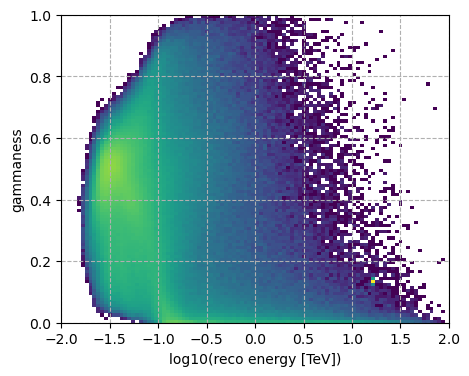

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))

m = ax.hist2d(data.log_reco_energy, data.gammaness,
         range=[[-2, 2], [0, 1]], bins=100, cmin=1, norm=colors.LogNorm())
ax.set_xlabel('log10(reco energy [TeV])')
ax.set_ylabel('gammaness')
ax.grid(ls='--')
fig.show()

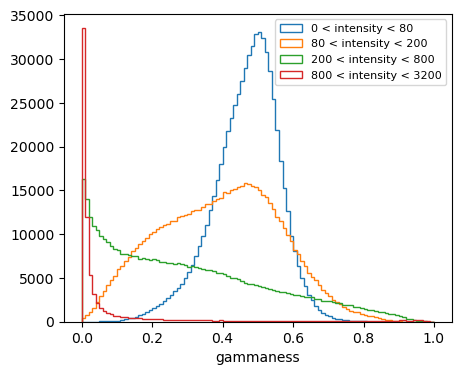

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))

intensity_cut_edges = [0, 80, 200, 800, 3200]
for i in range(len(intensity_cut_edges) - 1):
    intensity_cut = intensity_cut_edges[i:i+2]

    ax.hist(data.gammaness[(data.intensity > intensity_cut[0]) & (data.intensity <= intensity_cut[1])], 
             range=[0, 1], bins=100, histtype='step', label=f'{intensity_cut[0]} < intensity < {intensity_cut[1]}')
ax.set_xlabel('gammaness')
ax.legend(fontsize=8)
fig.show()

#### Effective time calculation

In [27]:
average_rate = 1/np.mean(data.delta_t)
deadtime = np.min(data.delta_t[data.delta_t>0]) * 1e6

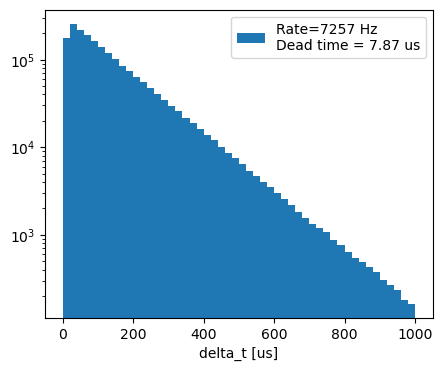

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(data.delta_t*1e6, range=[0, 1e3], bins=50,
        label=f'Rate={average_rate:.0f} Hz\nDead time = {deadtime:.2f} us')
ax.set_yscale('log')
ax.set_xlabel('delta_t [us]')
ax.legend()
fig.show()

In [29]:
t_eff, t_elapsed = get_effective_time(data)
#obstime_real = get_effective_time(data)[0]
print(f"Effective time {t_eff.to(u.min):.1f}")
print(f"Elapsed time {t_elapsed.to(u.min):.1f}")
print(f"Deadtime: {100 - t_eff/t_elapsed*100:.1f}%")

Effective time 6.5 min
Elapsed time 6.9 min
Deadtime: 5.7%


#### Data selection

In [30]:
gammaness_cut = 0.7
intensity_cut = 50 #p.e.

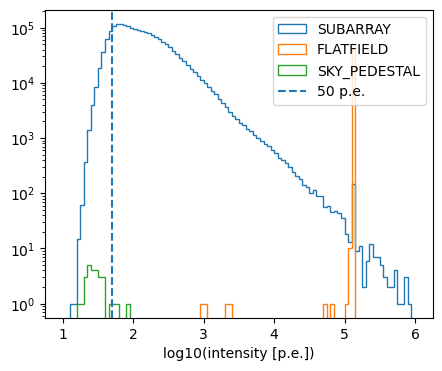

In [31]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(np.log10(data.intensity[data.event_type == EventType.SUBARRAY.value]), 
         range=[1, 6], bins=100, histtype='step', label='SUBARRAY')
ax.hist(np.log10(data.intensity[data.event_type == EventType.FLATFIELD.value]), 
         range=[1, 6], bins=100, histtype='step', label='FLATFIELD')
ax.hist(np.log10(data.intensity[data.event_type == EventType.SKY_PEDESTAL.value]), 
         range=[1, 6], bins=100, histtype='step', label='SKY_PEDESTAL')

ax.axvline(np.log10(intensity_cut), ls='--', label=f'{intensity_cut} p.e.')
ax.set_yscale('log')
ax.set_xlabel('log10(intensity [p.e.])')
ax.legend()
fig.show()

## 5. Create theta2 plots

In [32]:
condition = (data.gammaness > gammaness_cut) \
          & (data.intensity > intensity_cut) \
          & (data.event_type == EventType.SUBARRAY.value)

In [33]:
selected_data = data[condition] 
print(f'Total number of original events: {len(data)}')
print(f'Total number of selected events: {len(selected_data)}')

del data

Total number of original events: 1971055
Total number of selected events: 59833


#### Define theta2 range (ON and normalization region)

In [34]:
THETA2_GLOBAL_CUT = 0.04
theta2_range = (0, 1)
norm_theta2_range = (0.5, 1)

#### True source position

In [35]:
#If its a catalogued source, like the Crab, you can use this lstchain function
true_source_position = extract_source_position(selected_data, 'Crab')

In [36]:
"""
from lstchain.reco.utils import radec_to_camera

def extract_source_position_from_coord(
    data, coord, equivalent_focal_length=28 * u.m
):
    obstime = pd.to_datetime(data["dragon_time"], unit="s")
    pointing_alt = u.Quantity(data["alt_tel"], u.rad, copy=False)
    pointing_az = u.Quantity(data["az_tel"], u.rad, copy=False)
    source_pos_camera = radec_to_camera(
        coord,
        obstime,
        pointing_alt,
        pointing_az,
        focal=equivalent_focal_length,
    )
    source_position = [source_pos_camera.x, source_pos_camera.y]
    return source_position

coordinates = SkyCoord(ra = 83.6287 * u.degree, dec = 22.0147 * u.degree, frame='icrs')
true_source_position = extract_source_position_from_coord(selected_data, coordinates)
"""

'\nfrom lstchain.reco.utils import radec_to_camera\n\ndef extract_source_position_from_coord(\n    data, coord, equivalent_focal_length=28 * u.m\n):\n    obstime = pd.to_datetime(data["dragon_time"], unit="s")\n    pointing_alt = u.Quantity(data["alt_tel"], u.rad, copy=False)\n    pointing_az = u.Quantity(data["az_tel"], u.rad, copy=False)\n    source_pos_camera = radec_to_camera(\n        coord,\n        obstime,\n        pointing_alt,\n        pointing_az,\n        focal=equivalent_focal_length,\n    )\n    source_position = [source_pos_camera.x, source_pos_camera.y]\n    return source_position\n\ncoordinates = SkyCoord(ra = 83.6287 * u.degree, dec = 22.0147 * u.degree, frame=\'icrs\')\ntrue_source_position = extract_source_position_from_coord(selected_data, coordinates)\n'

#### Off source position

In [37]:
off_source_position = [element * -1 for element in true_source_position]

#### Compute theta2 for ON/OFF position

In [38]:
theta2_on = np.array(compute_theta2(selected_data, true_source_position))
theta2_off = np.array(compute_theta2(selected_data, off_source_position))

In [39]:
data_on = theta2_on
data_off = theta2_off
signal_cut = THETA2_GLOBAL_CUT
x_range = theta2_range
norm_x_range = norm_theta2_range 
x_label = "$\\theta^{2} [deg^{2}]$"
nbins=round((x_range[1]/signal_cut)*2) # Make the histogram so there are only two bins before the theta2 cut
#nbins = 100
nbins=round((theta2_range[1]/THETA2_GLOBAL_CUT)*2)

In [40]:
def plot_on_off_and_excess(data_on, data_off, signal_cut, nbins, x_range, norm_x_range, x_label,t_eff,  title=None):

    hist_on, bin_edges_on = np.histogram(data_on, density=False, bins=nbins, range=x_range)
    hist_off, bin_edges_off = np.histogram(data_off, density=False, bins=nbins, range=x_range)

    bin_width = bin_edges_on[1]-bin_edges_off[0]
    bin_center = bin_edges_on[:-1]+(bin_width/2)

    N_on = np.sum(hist_on[bin_edges_on[1:]<=signal_cut])
    N_off = np.sum(hist_off[bin_edges_off[1:]<=signal_cut])
    
    idx_min = (np.abs(bin_edges_on - norm_x_range[0])).argmin()
    idx_max = (np.abs(bin_edges_on - norm_x_range[1])).argmin()
    
    Non_norm = np.sum(hist_on[idx_min:idx_max])
    Noff_norm = np.sum(hist_off[idx_min:idx_max])
    
    alpha = Noff_norm / Non_norm
    
    stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
    significance_lima = stat.sqrt_ts

    excess = hist_on - hist_off
    excess_err = np.sqrt(hist_on + hist_off)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
    textstr = r'N$_{{\rm on}}$ = {:.0f}, N$_{{\rm off}}$ = {:.0f} '\
                f'\n'\
                r'Time = {:.1f}'\
                f'\n'\
                r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                          N_off,
                                                          t_eff.to(u.h),
                                                          significance_lima)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if title is not None:
        fig.suptitle(title)
        
    #ax[0].hist(bin_center, weights=hist_on, bins=nbins, range=theta2_range, histtype='step', lw=2, color='tab:blue')
    ax[0].errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', color='tab:blue')
    ax[0].hist(bin_center, weights=hist_off, bins=nbins, range=x_range, histtype='step', lw=2, color='tab:orange', zorder=1)
    ax[0].errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='.',label='Background', color='tab:orange', zorder=1)
    ax[0].grid(ls='dashed')
    ax[0].axvline(signal_cut, color='black',ls='--',alpha=0.75)
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel("Counts")
    ax[0].legend(loc='lower right')
    ax[0].text(0.45, 0.95, textstr, transform=ax[0].transAxes, verticalalignment='top', bbox=props)
    
    ax[1].errorbar(bin_center, excess, yerr=excess_err,fmt='o',color='forestgreen',label='Excess counts')
    ax[1].bar(bin_edges_on[:-1], excess, width = bin_width, align='edge', color='limegreen',alpha=0.5)
    ax[1].axhline(0, color='darkgray')
    ax[1].grid()
    ax[1].axvline(signal_cut, color='black', ls='--', alpha=0.75)
    ax[1].grid(ls='dashed')
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel("Counts")
    ax[1].legend(title=f'Significance = {significance_lima:.1f} $\sigma$')

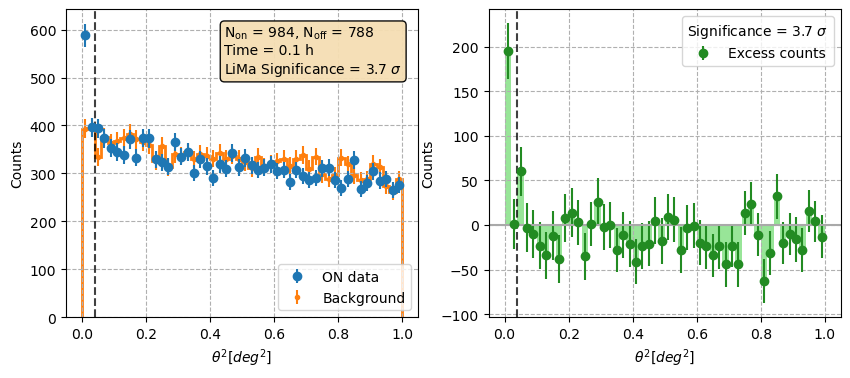

In [41]:
plot_on_off_and_excess(data_on, data_off, signal_cut, nbins, x_range, norm_x_range, x_label, t_eff)

In [42]:
log_reco_energy = np.array(selected_data.log_reco_energy)
emin=0.01 * u.TeV
emax=10 * u.TeV
n_bins_energy=2
log_energy = np.linspace(np.log10(emin.to_value()),
                         np.log10(emax.to_value()),
                         n_bins_energy + 1)

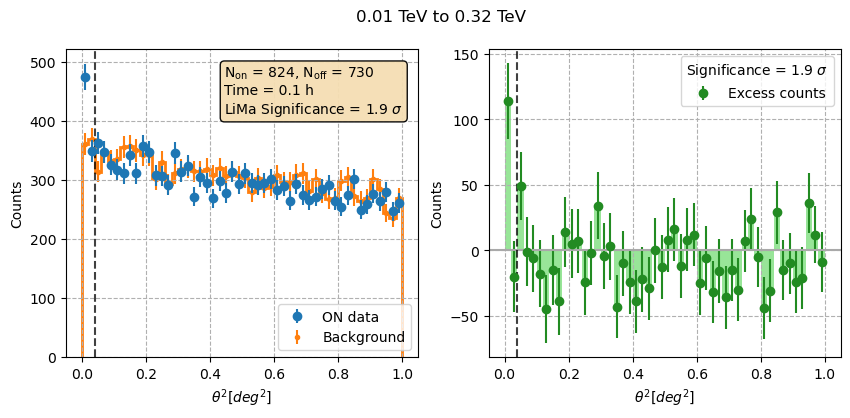

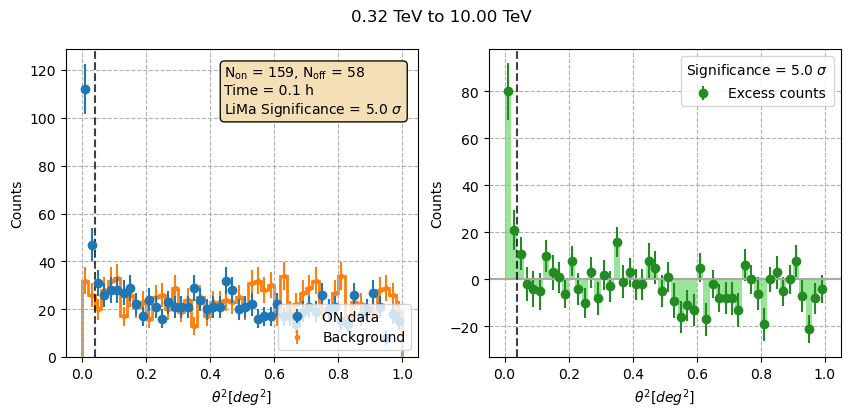

In [43]:

for i in range(n_bins_energy):
    condition_energy_bin= (selected_data.log_reco_energy < log_energy[i+1]) & (selected_data.log_reco_energy >= log_energy[i])

    title_txt = f'{10**log_energy[i]:.2f} TeV to {10**log_energy[i+1]:.2f} TeV'
    plot_on_off_and_excess(data_on[condition_energy_bin], data_off[condition_energy_bin], signal_cut, nbins, x_range, norm_x_range, x_label, t_eff, title_txt)


# 5. source-dependent DL2

Let's analyze the data in a different method: source-dependent approach. For the source-dependent analysis, several parameters are computed with an assumption of the expected source position (e.g. `alpha`, `dist`). Thanks to a pri-ori information, the reconstruction performance (e.g. energy bias) is better than the standard approach although there is not so much difference in the sensitivity curve because background condition (S/N>5%) affected the low-energy region.
However, this approach is helpful for the pulsar analysis.
Please note that this approach can be used only for the point source.

You need to activate `source_dependent` as `True` in the config file. Then you also need to set `source_name` (or `source_ra` and `source_dec`) and `n_off`

In [44]:
srcdep_related_config_keys = [
    'source_dependent',
    'energy_regression_features',
    'particle_classification_features',
    'n_off_wobble',
    'source_name',
    'source_ra',
    'source_dec'
]

for key in srcdep_related_config_keys:
    print(f"{key} : {srcdep_config[key]}")

source_dependent : True
energy_regression_features : ['log_intensity', 'width', 'length', 'wl', 'skewness_from_source', 'kurtosis', 'time_gradient_from_source', 'leakage_intensity_width_2', 'dist', 'alt_tel', 'sin_az_tel']
particle_classification_features : ['log_intensity', 'width', 'length', 'wl', 'skewness_from_source', 'kurtosis', 'time_gradient_from_source', 'leakage_intensity_width_2', 'log_reco_energy', 'dist', 'reco_disp_norm_diff', 'reco_disp_sign_correctness', 'alt_tel', 'sin_az_tel']
n_off_wobble : 1
source_name : Crab Nebula
source_ra : 83.63308333
source_dec : 22.0145


In [45]:
model_path = f'{data_dir}/models/srcdep'
output_dir = "DL2_ouput_srcdep"
os.makedirs(output_dir, exist_ok=True)
config_file = f'{lstchain_dir}/data/lstchain_src_dep_config.json'

In [46]:
!lstchain_dl1_to_dl2 -f {input_dl1_file} -p {model_path} -o {output_dir} -c {config_file}

/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/site-packages/lstchain/reco/utils.py:535: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
Data contains not-predictable events.
Column | Number of non finite values
skewness_from_source : 87
time_gradient_from_source : 92
skewness : 87
width : 87
length : 87
kurtosis : 87
leakage_intensity_width_2 : 87
log_intensity : 87
wl : 87
time_gradient : 92
dist : 87
/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/site-packages/lstchain/reco/utils.py:535: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/fefs/aswg/workspace/seiya.nozaki/Install/anaconda3/envs/lst_v0.10.4/lib/python3.11/

## Explore source-dependent DL2 data

#### Check DL2 data

Here let's use the already-processed DL2 data (run 16179, merge of 50 subruns).

In [47]:
dl2_file_path = f'{data_dir}/DL2/srcdep/dl2_LST-1.Run16179_small.h5'

DL1 dataset is replaced with `/dl2/event/telescope/parameters/LST_LSTCam`. In addition, source-dependent DL2 parameters are stored in `/dl2/event/telescope/parameters_src_dependent/LST_LSTCam`

In [48]:
get_dataset_keys(dl2_file_path)

['/source_filenames/filenames',
 '/dl2/event/telescope/parameters/LST_LSTCam',
 '/dl2/event/telescope/parameters_src_dependent/LST_LSTCam',
 '/dl1/event/telescope/monitoring/calibration',
 '/dl1/event/telescope/monitoring/flatfield',
 '/dl1/event/telescope/monitoring/pedestal',
 '/configuration/instrument/subarray/layout',
 '/configuration/instrument/telescope/optics',
 '/configuration/instrument/telescope/camera/geometry_0',
 '/configuration/instrument/telescope/camera/readout_0']

In [49]:
data = pd.read_hdf(dl2_file_path, key=dl2_params_lstcam_key)
data

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type,delta_t
0,16179,1,5656.835428,3.752574,0.008245,-0.022202,0.023683,-1.215231,1.137678,0.007587,...,0.969063,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000000
1,16179,2,62.134762,1.793335,-0.565006,0.595677,0.821013,2.329776,0.061903,0.004842,...,0.977951,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000014
2,16179,6,118.360357,2.073206,-0.107376,-0.948771,0.954828,-1.683491,0.076276,0.005181,...,0.800379,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000063
3,16179,13,60.150925,1.779242,0.073985,0.720996,0.724782,1.468539,0.065001,0.006597,...,0.586630,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000145
4,16179,15,86.777166,1.938405,-0.080935,0.247501,0.260398,1.886845,0.114150,0.006107,...,0.552036,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971050,16179,2990393,157.264020,2.196629,-0.104012,0.988009,0.993469,1.675684,0.100834,0.004590,...,0.610606,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000066
1971051,16179,2990394,183.859056,2.264485,0.619408,-0.551759,0.829521,-0.727700,0.083534,0.004676,...,0.674511,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000057
1971052,16179,2990396,129198.666480,5.111258,0.001618,0.001983,0.002559,0.886249,1.160132,0.001619,...,0.996720,1,-5.86377,60.376717,0.882712,0,5,1.702779e+09,0,0.000080
1971053,16179,2990398,53.861617,1.731279,0.310176,-0.348407,0.466473,-0.843385,0.068918,0.004181,...,0.578875,1,-5.86377,60.376717,0.882712,0,1,1.702779e+09,32,0.000226


In [ ]:
data_srcdep = get_srcdep_params(dl2_file_path)

In [ ]:
get_srcdep_assumed_positions(dl2_file_path)

In [ ]:
data_srcdep['on'].head()

In [ ]:
data_srcdep['off_180'].head()

In [ ]:
data_srcdep['on'].keys()

In [ ]:
t_eff, t_elapsed = get_effective_time(data)

print(f"Effective time {t_eff.to(u.min):.1f}, Elapsed time {t_elapsed.to(u.min):.1f}")
print(f"Deadtime: {100 - t_eff/t_elapsed*100:.1f}%")

In [ ]:
gammaness_cut = 0.7
intensity_cut = 50 #p.e.

In [ ]:
condition_on = (data_srcdep['on'].gammaness > gammaness_cut) \
          & (data.intensity > intensity_cut) \
          & (data.event_type == EventType.SUBARRAY.value)

condition_off = (data_srcdep['off_180'].gammaness > gammaness_cut) \
          & (data.intensity > intensity_cut) \
          & (data.event_type == EventType.SUBARRAY.value)

In [ ]:
selected_data_on = data_srcdep['on'][condition_on]
selected_data_off = data_srcdep['off_180'][condition_off]

del data
del data_srcdep

In [ ]:
# alpha cut
signal_cut = 10 
x_range = (0, 90)
norm_x_range = (50, 90)
x_label = r"$\alpha$ [deg]"

In [ ]:
data_on = selected_data_on.alpha
data_off = selected_data_off.alpha

plot_on_off_and_excess(data_on, data_off, signal_cut, nbins, x_range, norm_x_range, x_label, t_eff)

In [ ]:
log_reco_energy = np.array(selected_data.log_reco_energy)
emin=0.01 * u.TeV
emax=10 * u.TeV
n_bins_energy=2
log_energy = np.linspace(np.log10(emin.to_value()),
                         np.log10(emax.to_value()),
                         n_bins_energy + 1)

In [ ]:
for i in range(n_bins_energy):
    condition_on_energy_bin= (selected_data_on.log_reco_energy < log_energy[i+1]) & (selected_data_on.log_reco_energy >= log_energy[i])
    condition_off_energy_bin= (selected_data_off.log_reco_energy < log_energy[i+1]) & (selected_data_off.log_reco_energy >= log_energy[i])

    title_txt = f'{10**log_energy[i]:.2f} TeV to {10**log_energy[i+1]:.2f} TeV'
    plot_on_off_and_excess(data_on[condition_on_energy_bin], data_off[condition_off_energy_bin], signal_cut, nbins, x_range, norm_x_range, x_label, t_eff,  title_txt)